## <u>*Classsification Modelling for age category as a Target Feature*</u>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from datetime import datetime,time
import os
import json

In [2]:
from sklearn.metrics import (
    r2_score,accuracy_score,roc_auc_score,auc,roc_curve,precision_score,
    recall_score,precision_recall_curve,r2_score,classification_report,RocCurveDisplay,
    confusion_matrix,f1_score,ConfusionMatrixDisplay
    )
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBRFClassifier
import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score,KFold
import warnings                                  
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder,StandardScaler
from tqdm import tqdm
from sklearn.utils.multiclass import unique_labels
import plotclassification ,plotly
# import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK,Trials

---

*Importing Data :*

In [3]:
df=pd.read_csv(r"C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/Data_Sets/data_car.csv")
df=df.drop(["X_OBSTAT_","clm","numclaims"],axis=1)
df["agecat"]=df["agecat"].astype("object")
df["veh_age"]=df["veh_age"].astype("object")
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,1.06,0.303901,0.0,HBACK,3,F,C,2
1,1.03,0.648871,0.0,HBACK,2,F,A,4
2,3.26,0.569473,0.0,UTE,2,F,E,2
3,4.14,0.317591,0.0,STNWG,2,F,D,2
4,0.72,0.648871,0.0,HBACK,4,F,C,2


---

*Sorting Data :*

In [4]:
df=df.sort_values(by=['veh_age', 'agecat','area','gender']).reset_index().drop("index",axis=1)
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,1.59,0.229979,0.0,SEDAN,1,F,A,1
1,1.46,0.221766,0.0,HBACK,1,F,A,1
2,1.54,0.238193,0.0,SEDAN,1,F,A,1
3,1.57,0.522930,0.0,SEDAN,1,F,A,1
4,1.41,0.219028,0.0,HBACK,1,F,A,1


---

*Data Shape :*

In [5]:
df.shape

(67856, 8)

---

*Define categorical features and numerical features :*

In [6]:
categorical_features=df.select_dtypes(include=["object"])
numerical_features=df.select_dtypes(exclude=["object"])

print("we have {} numerical features : {}\n".format(numerical_features.shape[1],list(numerical_features.columns)))
print("we have {} categorical features : {}".format(categorical_features.shape[1],list(categorical_features.columns)))

we have 3 numerical features : ['veh_value', 'exposure', 'claimcst0']

we have 5 categorical features : ['veh_body', 'veh_age', 'gender', 'area', 'agecat']


---

*Categorical features Frequency percenatge :*

In [7]:
for col in categorical_features:
    print(df[col].value_counts(normalize=True)*100)

veh_body
SEDAN    32.764973
HBACK    27.875206
STNWG    23.963983
UTE       6.758430
TRUCK     2.578991
HDTOP     2.326987
COUPE     1.149493
PANVN     1.108229
MIBUS     1.056649
MCARA     0.187161
CONVT     0.119370
BUS       0.070738
RDSTR     0.039790
Name: proportion, dtype: float64
veh_age
3    29.568498
4    27.923839
2    24.444412
1    18.063252
Name: proportion, dtype: float64
gender
F    56.88959
M    43.11041
Name: proportion, dtype: float64
area
C    30.269983
A    24.039142
B    19.660752
D    12.044624
E     8.712568
F     5.272931
Name: proportion, dtype: float64
agecat
4    23.857876
3    23.235970
2    18.974004
5    15.821740
6     9.648373
1     8.462037
Name: proportion, dtype: float64


---

*Visualizing numerical features :*

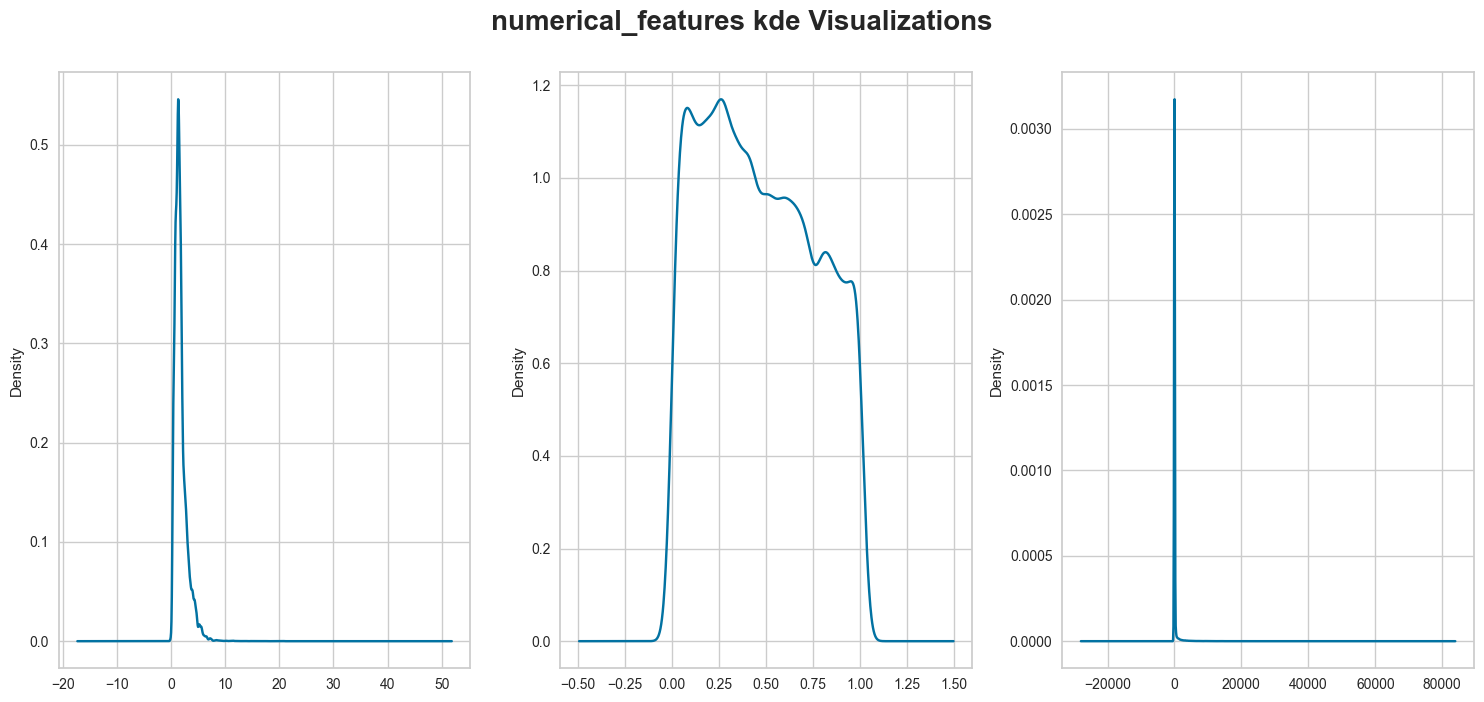

In [9]:
def plot_numerical_features(numerical_features,ChartType):
    nrows = 1
    ncols = 3

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,7))
    fig.suptitle(f"numerical_features {ChartType} Visualizations",fontsize=20,fontweight="bold",y=1.)
    
    axes = axes.flatten()

    for i, column in enumerate(numerical_features.columns):
        if i >= nrows * ncols:
            break 
        numerical_features[column].plot(ax=axes[i], kind=f"{ChartType}")
        plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/generalGraphs/plot_numerical_features.png',dpi=500);
        


    plt.tight_layout()
    plt.show()

plot_numerical_features(numerical_features[["veh_value","exposure","claimcst0"]],"kde")


---

*Visualizing categorical features :*

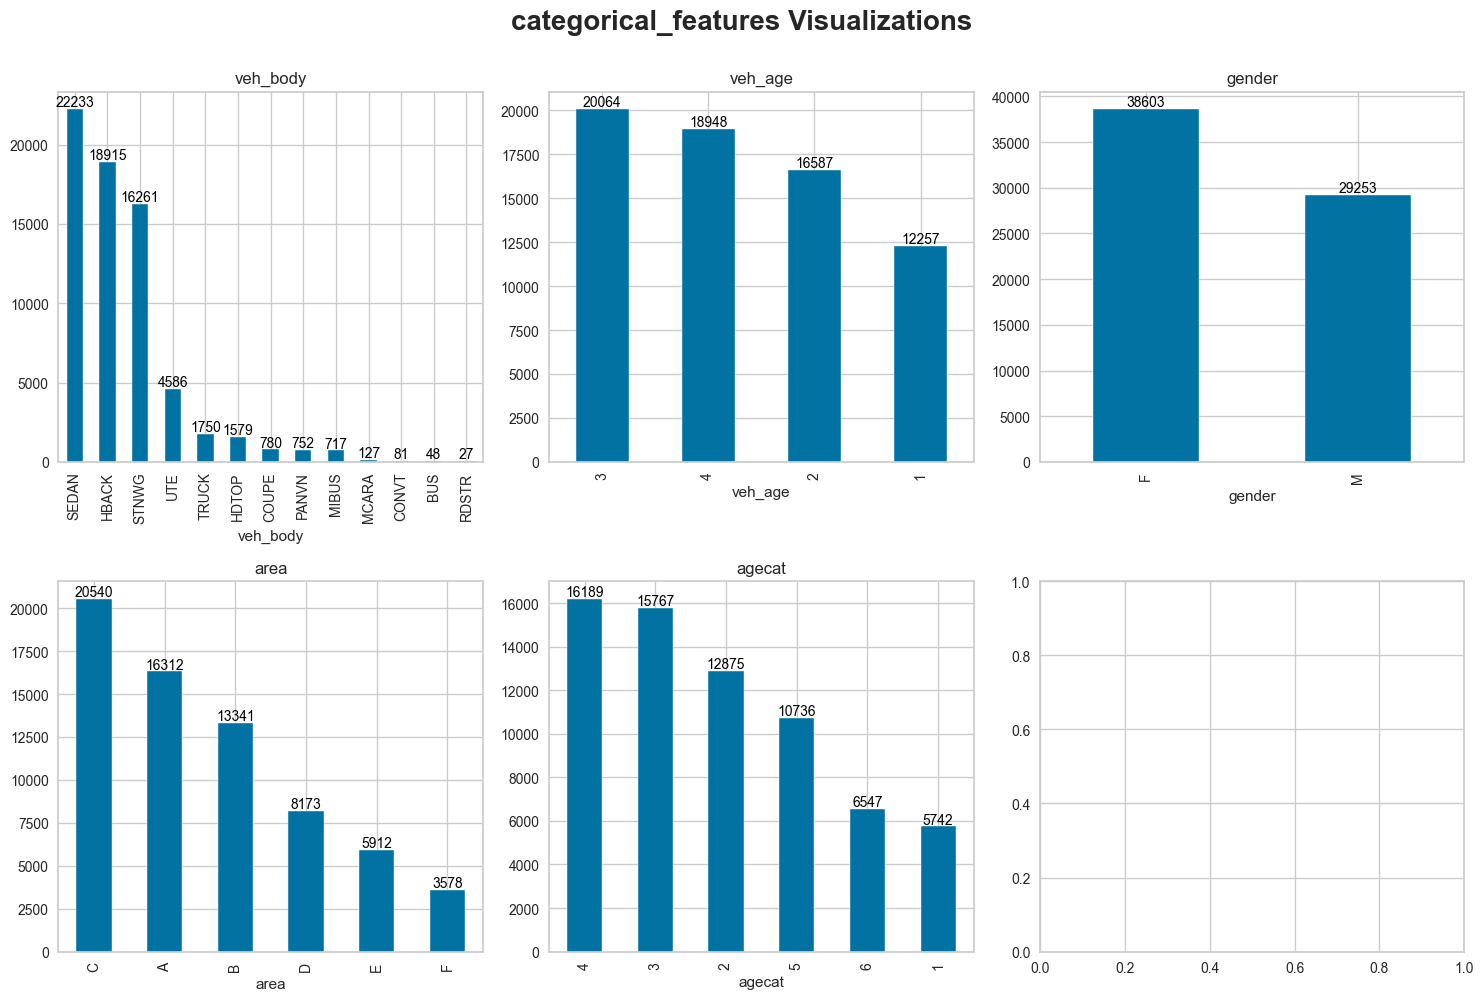

In [10]:
def plot_categorical_features(categorical_features):
    nrows = 2
    ncols = 3
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
    fig.suptitle(f"categorical_features Visualizations",fontsize=20,fontweight="bold",y=1.)

    axes = axes.flatten()
    
    for i, column in enumerate(categorical_features.columns):
        if i >= nrows * ncols:
            break 
        ax = axes[i]
        counts = categorical_features[column].value_counts()
        counts.plot(kind='bar', ax=ax, title=column)
        
        for bar in ax.patches:
            ax.annotate(
                str(bar.get_height()),
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points'
            )
        plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/generalGraphs/plot_categorical_features.png',dpi=500);
        
    plt.tight_layout()
    plt.show()

plot_categorical_features(categorical_features)    

---

*Define discretes feature and countinuous features :*

In [11]:
discrete_feature=[feature for feature in numerical_features if  len(df[feature].unique())<=25]
countinuous_feature=[feature for feature in numerical_features if  len(df[feature].unique())>25]

In [12]:

print("we have {} discrete feature : {}\n".format(len(discrete_feature),(discrete_feature)))
print("we have {} countinuous feature : {}".format(len(countinuous_feature),(countinuous_feature)))

we have 0 discrete feature : []

we have 3 countinuous feature : ['veh_value', 'exposure', 'claimcst0']


---

*Categorical features Frequency percenatge by gender :*

In [13]:
df.groupby("gender")["agecat"].value_counts(normalize=True).to_frame()*100

proportion
gender agecat            
F      4        24.293449
       3        24.140611
       2        19.718675
       5        14.944434
       1         8.481206
       6         8.421625
M      4        23.283082
       3        22.042184
       2        17.991317
       5        16.979455
       6        11.267220
       1         8.436742

* *Insights :*

*1. Area C has the highest Proportion between genders*

*2. Area F has the lowest Proportion between genders*

In [14]:
df.groupby("area")["agecat"].value_counts(normalize=True).to_frame()*100

proportion
area agecat            
A    4        24.460520
     3        22.314860
     2        18.311672
     5        15.896273
     6        10.513732
     1         8.502943
B    3        23.828798
     4        23.281613
     2        18.986583
     5        16.617945
     6         9.467056
     1         7.818005
C    4        25.048685
     3        22.195716
     2        18.534567
     5        16.119766
     6         9.386563
     1         8.714703
D    3        23.638811
     4        23.112688
     2        16.823688
     5        16.799217
     6        11.525756
     1         8.099841
E    3        24.729364
     4        22.817997
     2        18.115697
     5        15.747632
     6        10.774696
     1         7.814614
F    2        30.799329
     3        27.808832
     4        19.843488
     1        11.123533
     5         8.692007
     6         1.732812

* *Insights :*

*1. Area C has the highest Proportion among  all age categories*

*2. Area F has the lowest Proportion among  all age categories except age categorty 2 where Area E has the lowest*

In [15]:
df.groupby("veh_age")["agecat"].value_counts(normalize=True).to_frame()*100

proportion
veh_age agecat            
1       4        23.945501
        3        22.077180
        2        17.622583
        5        16.659868
        1        10.467488
        6         9.227380
2       4        23.626937
        3        22.553807
        2        19.093266
        5        15.885935
        6         9.772714
        1         9.067342
3       3        24.053030
        4        23.724083
        2        19.716906
        5        15.390750
        6         8.926435
        1         8.188796
4       4        24.145028
        3        23.717543
        2        18.957146
        5        15.679755
        6        10.576314
        1         6.924214

* *Insights :*

*1. Area C has the highest Proportion among  all veh age categories*

*2. Area F has the lowest Proportion among  all veh age categories*

In [16]:
df.groupby("veh_body")["agecat"].value_counts(normalize=True).to_frame()*100

proportion
veh_body agecat            
BUS      1        22.916667
         3        22.916667
         5        20.833333
         4        18.750000
         2        10.416667
...                     ...
UTE      3        23.658962
         4        20.889664
         5        14.042739
         1        12.734409
         6         4.186655

[78 rows x 1 columns]

* *Insights :*

*A. :*

---

*Visualizing Categorical and numerical features by gender :*

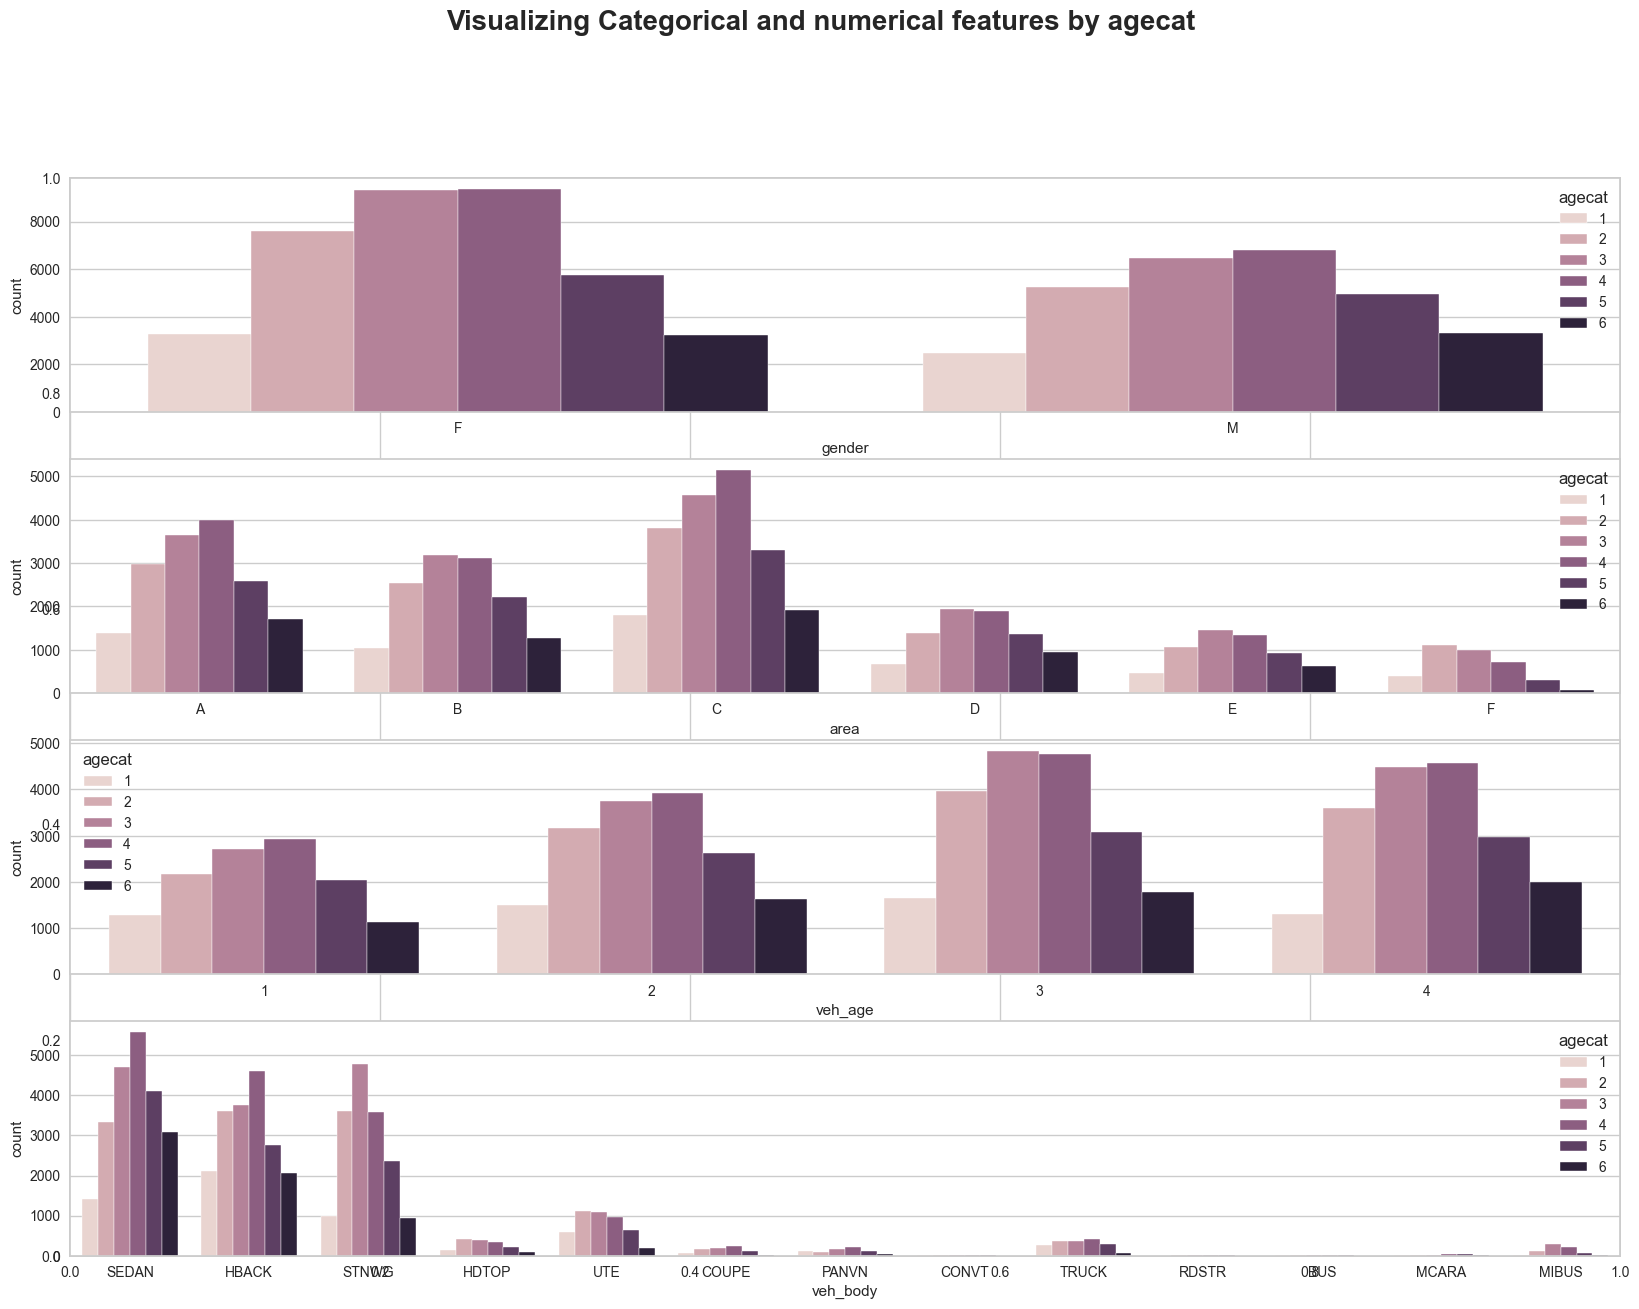

In [21]:
plt.subplots(figsize=(20,14))
plt.suptitle(f"Visualizing Categorical and numerical features by agecat",fontsize=20,fontweight="bold",y=1.)
plt.subplot(411)
sns.countplot(x="gender",hue="agecat",data=df)
plt.subplot(412)
sns.countplot(x="area",hue="agecat",data=df)
plt.subplot(413)
sns.countplot(x="veh_age",hue="agecat",data=df)
plt.subplot(414)
sns.countplot(x="veh_body",hue="agecat",data=df);
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresbytargetGraphs/plot_features_by_agecat1.png',dpi=500);

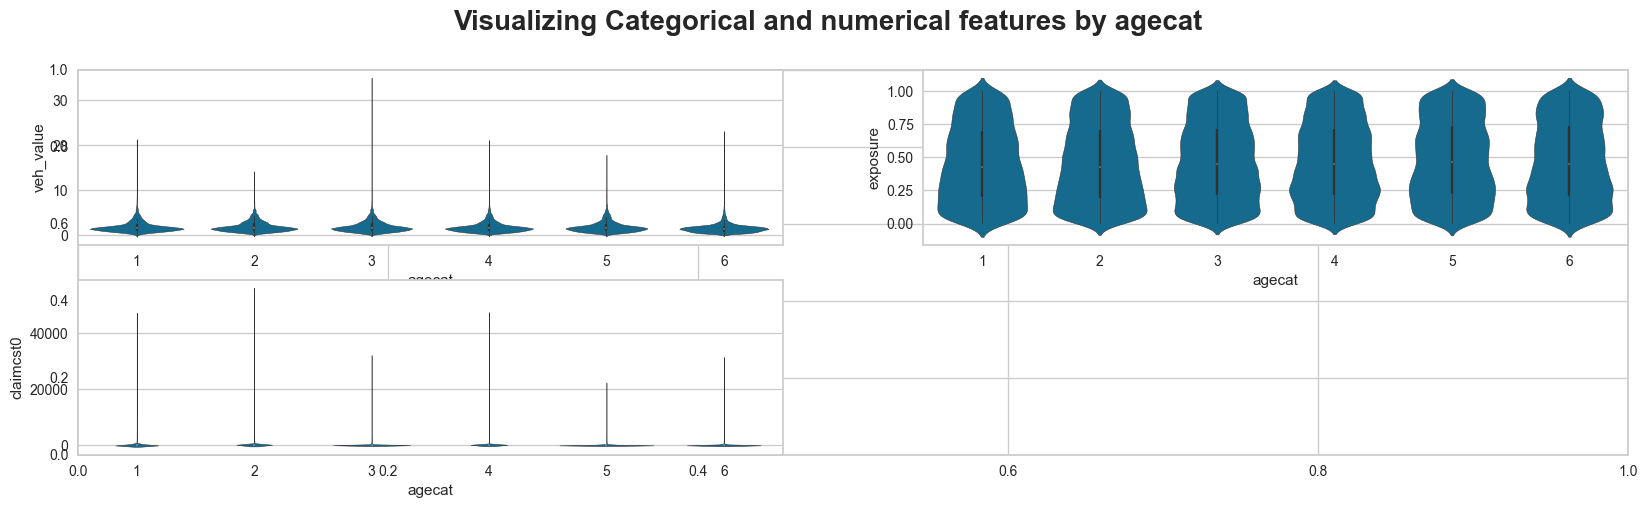

In [24]:
plt.subplots(figsize=(20,5))
plt.suptitle(f"Visualizing Categorical and numerical features by agecat",fontsize=20,fontweight="bold",y=1.)
plt.subplot(221)
sns.violinplot(x="agecat",y="veh_value",data=df)
plt.subplot(222)
sns.violinplot(x="agecat",y="exposure",data=df)
plt.subplot(223)
sns.violinplot(x="agecat",y="claimcst0",data=df)
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresbytargetGraphs/plot_features_by_agecat2.png',dpi=500);

---

In [25]:
categories_encoder=LabelEncoder()
for col in df:
    if col in list(df.select_dtypes(include="object").columns):
        df[col]=categories_encoder.fit_transform(df[col])

*Define x and y*

In [85]:
x=df.drop("agecat",axis=1)
y=df["agecat"]

---

*Countinuous features Skewbess -outliers-*

In [86]:
x[countinuous_feature].skew(axis=0,skipna=True)

veh_value     2.968022
exposure      0.175557
claimcst0    17.502503
dtype: float64

---

*Transforming countinuous features to handle the outliers*

In [28]:
from sklearn.preprocessing import PowerTransformer
pt=PowerTransformer(method="yeo-johnson")
transform_features=['veh_value', 'claimcst0']
x_copy=pt.fit_transform(x[transform_features])

In [29]:
x_copy=pd.DataFrame(x_copy,columns=transform_features)
x_copy

,veh_value,claimcst0
0,0.103702,-0.270421
1,-0.043000,-0.270421
2,0.048639,-0.270421
3,0.081874,-0.270421
4,-0.102624,-0.270421
...,...,...
67851,-0.446192,-0.270421
67852,0.229457,-0.270421
67853,-2.565485,-0.270421
67854,-0.877562,-0.270421


In [30]:
x_copy.skew(axis=0,skipna=True)

veh_value    0.010369
claimcst0    3.427592
dtype: float64

---

*Visualizing  countinuous features after tranformation  :*

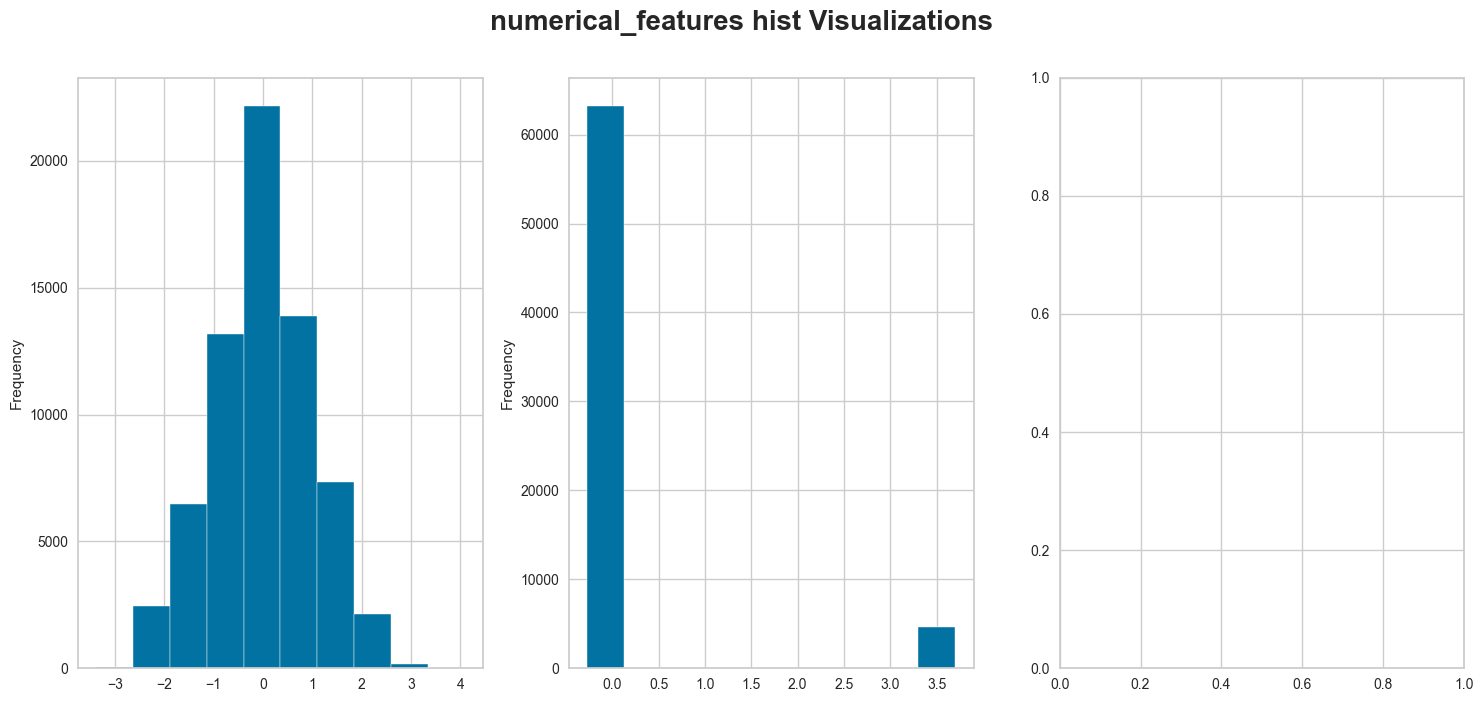

In [23]:
plot_numerical_features(x_copy[["veh_value","claimcst0"]],"hist")

---

In [31]:
for feature in categorical_features:
    print(feature,":",df[feature].unique())

veh_body : [ 9  3 10  4 12  2  7  1 11  8  0  5  6]
veh_age : [0 1 2 3]
gender : [0 1]
area : [0 1 2 3 4 5]
agecat : [0 1 2 3 4 5]


In [32]:
for feature in categorical_features:
    print(feature,":",df[feature].nunique())

veh_body : 13
veh_age : 4
gender : 2
area : 6
agecat : 6


---

*Apply ColumnTransformer to do all transdormation in once :*

In [94]:
from sklearn.preprocessing import PowerTransformer,StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [95]:
from sklearn.preprocessing import PowerTransformer
pt=PowerTransformer(method="yeo-johnson")
transform_features=['veh_value', 'claimcst0']
df[transform_features]=pt.fit_transform(x[transform_features])

In [96]:
sc=StandardScaler()
onencood=OneHotEncoder()
ordinalencod=OrdinalEncoder()
transform_pipe=Pipeline(steps=[
    ("transformer",PowerTransformer(method="yeo-johnson"))
    ])

In [99]:
preprocessor=ColumnTransformer([
    #("OneHotEncoder",onencood,on_columns),
    #("Ordinal_Encoder",ordinalencod,ordered_columns),
    #("transformer",transform_pipe,transform_features),
    ("StandardScaler",sc,x.columns)
]
)

In [100]:
x=preprocessor.fit_transform(x)

---

*Hundling unbalanced data :*

In [102]:
from imblearn.combine import SMOTETomek,SMOTEENN
smt=SMOTEENN(random_state=42,sampling_strategy="minority")
x_re,y_res=smt.fit_resample(x,y)


---

*Split data into train and test subdata :*

In [103]:
x_train, x_test, y_train, y_test = train_test_split(x_re,y_res ,test_size= 0.2,random_state=42)

print("Train data shape of X = % s and Y = % s : "%(
	x_train.shape, y_train.shape))

print("Test data shape of X = % s and Y = % s : "%(
	x_test.shape, y_test.shape))

Train data shape of X = (3489, 7) and Y = (3489,) : 
Test data shape of X = (873, 7) and Y = (873,) : 


---

*Define models :*

In [104]:
models = {
        
        "XGBRFClassifier": XGBRFClassifier(),
        "GradientBoostingClassifier":GradientBoostingClassifier(),
        "RandomForestClassifier": RandomForestClassifier(),
        "AdaBoostClassifier":AdaBoostClassifier(),
        "DecisionTreeClassifier": DecisionTreeClassifier(),
        "LogisticRegression":LogisticRegression(multi_class="ovr"),
        "SVC":SVC(decision_function_shape="ovr"),
        "KNeighborsClassifier":KNeighborsClassifier()
        
}

---

*Define evaluation funtion :*

In [105]:
def evaluation_preds_list(y_true,predicted):
    accuracy=accuracy_score(y_true,predicted)
    metrics_dict={
       "accuracy": round(accuracy,3),
          }
   
    return metrics_dict

In [106]:
def evaluation_preds(y_true,predicted):
    accuracy=accuracy_score(y_true,predicted)
    return accuracy

---

*Create one function to model the data :*

In [107]:
def evalua_models(x,y,models):
    x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size= 0.20,random_state=42)
    models_list=[]
    accuracy_list=[]

    for i in  range(len(list(models))):
        model=list(models.values())[i]
        model.fit(x_train,y_train)

        train_predicted=model.predict(x_train)
        test_predicted=model.predict(x_test)      
        
        test_predicted_accuracy=evaluation_preds(y_test,test_predicted)
       
        accuracy_list.append(test_predicted_accuracy)

        print(list(models.keys())[i])
        
        models_list.append(list(models.keys())[i])
        
        print( test_predicted_accuracy)
        print("===========================")

    report=pd.DataFrame(list(zip(models_list,accuracy_list)),columns=["model","acc"]).sort_values(by="acc",ascending=False) 
    return report
  

---

*Apply Data Modeling*

In [108]:
evalua_models(x_re,y_res,models)

XGBRFClassifier
0.8533791523482245
GradientBoostingClassifier
0.854524627720504
RandomForestClassifier
0.9140893470790378
AdaBoostClassifier
0.5647193585337915
DecisionTreeClassifier
0.8900343642611683
LogisticRegression
0.8487972508591065
SVC
0.8487972508591065
KNeighborsClassifier
0.8591065292096219


,model,acc
2,RandomForestClassifier,0.914089
4,DecisionTreeClassifier,0.890034
7,KNeighborsClassifier,0.859107
1,GradientBoostingClassifier,0.854525
0,XGBRFClassifier,0.853379
5,LogisticRegression,0.848797
6,SVC,0.848797
3,AdaBoostClassifier,0.564719


---

*Apply RandomForestClassifier :*

In [109]:
np.random.seed(42)
clf=RandomForestClassifier()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)

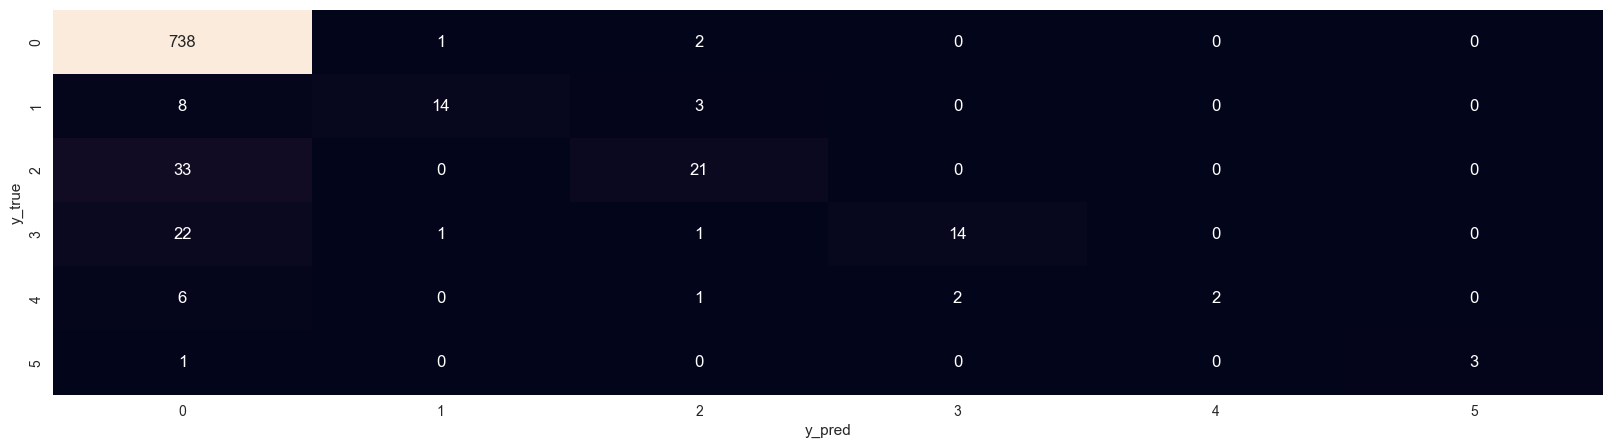

In [120]:
matplotlib.rcParams["figure.figsize"]=(20,5)
sns.heatmap(confusion_matrix(y_test,predicted),annot = True, fmt = ".0f",cbar=False)
plt.xlabel("y_pred")
plt.ylabel("y_true");
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/confusionMatrixGraphs/agecat_confusion_matrixPlot.png',dpi=500);

In [111]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       741
           1       0.88      0.56      0.68        25
           2       0.75      0.39      0.51        54
           3       0.88      0.37      0.52        38
           4       1.00      0.18      0.31        11
           5       1.00      0.75      0.86         4

    accuracy                           0.91       873
   macro avg       0.90      0.54      0.64       873
weighted avg       0.90      0.91      0.89       873



---

In [115]:
clf.feature_importances_.sum()

np.float64(1.0)

In [114]:
clf.feature_names_in=list(df.drop("agecat",axis=1).columns)
importance=pd.concat([pd.DataFrame(clf.feature_names_in,columns=["feature_names"]),
           pd.DataFrame(clf.feature_importances_,columns=["feature_importances"])],axis=1)
importance

,feature_names,feature_importances
0,veh_value,0.304572
1,exposure,0.319864
2,claimcst0,0.029402
3,veh_body,0.121725
4,veh_age,0.066781
5,gender,0.035864
6,area,0.121792


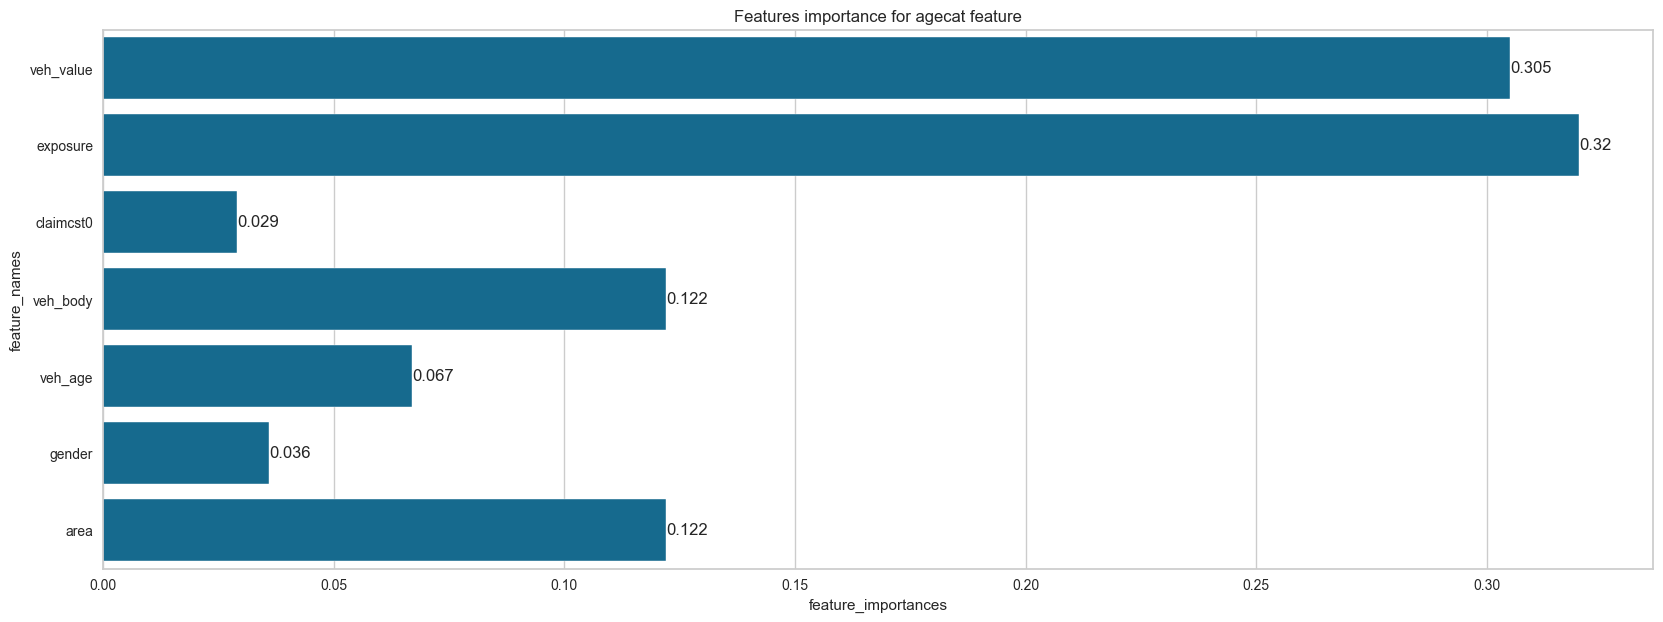

In [116]:
matplotlib.rcParams["figure.figsize"]=(20,7)
ax=sns.barplot(x=np.round(importance["feature_importances"],3),y=importance["feature_names"])
plt.title('Features importance for agecat feature')
ax.bar_label(ax.containers[0]);
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresImportanceGraphs/agecat_featureImportanc.png',dpi=500);

*Saving Best model :*

In [117]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/bestModels/agecat_prediction_model.pkl","wb") as f:
    pickle.dump(clf,f)

---